<a href="https://colab.research.google.com/github/siddharth0517/Predictive-Maintenance-for-Manufacturing/blob/main/Predictive_Maintenance_for_Manufacturing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd


# Importing Dataset

In [2]:
data = pd.read_csv('Data.csv')

In [3]:
df_info = pd.concat ( [data.isna().sum() , data.nunique() , data.dtypes] , axis = 1  )
df_info.columns = ['missing value' , 'number unique value' , 'dtype']
df_info

,missing value,number unique value,dtype
UDI,0,10000,int64
Product ID,0,10000,object
Type,0,3,object
Air temperature [K],0,93,float64
Process temperature [K],0,82,float64
Rotational speed [rpm],0,941,int64
Torque [Nm],0,577,float64
Tool wear [min],0,246,int64
Target,0,2,int64
Failure Type,0,6,object


In [4]:
X = data.iloc[: , 2:8].values
y = data.iloc[: , 8:10].values


# Data Preprocessing

**Encoding Categorical Data**

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [11]:
from sklearn.preprocessing import LabelEncoder


target = y[:, 0]
failure_type = y[:, 1]


le = LabelEncoder()
failure_type_encoded = le.fit_transform(failure_type)

y = np.column_stack((target, failure_type_encoded))

In [14]:
print(y)

[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 1]
 [0 1]]


# Splitting Dataset

In [12]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size =0.2, random_state=1)

**Feature Scaling**

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xtrain[:,1:] = sc.fit_transform(Xtrain[:,1:])
Xtest[:,1:] = sc.transform(Xtest[:,1:])

In [16]:
ytrain_target = ytrain[:, 0]  # Binary classification target
ytrain_failure_type = ytrain[:, 1]  # Multi-class classification (encoded failure type)

ytest_target = ytest[:, 0]
ytest_failure_type = ytest[:, 1]

# Training the Model

In [17]:
from xgboost import XGBClassifier
xgb_target = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_target.fit(Xtrain, ytrain_target)

# Training the Model for 'Failure Type' (multi-class classification)
xgb_failure_type = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_failure_type.fit(Xtrain, ytrain_failure_type)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:16:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

# Predicting

In [19]:
y_pred_target = xgb_target.predict(Xtest)
y_pred_failure_type = xgb_failure_type.predict(Xtest)


In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Ensure the target values are integers
ytest_target = ytest[:, 0].astype(int)  # Binary classification target
y_pred_target = np.round(y_pred_target).astype(int)

ytest_failure_type = ytest[:, 1].astype(int)  # Multi-class classification failure type
y_pred_failure_type = y_pred_failure_type.astype(int)

# Check unique values again after conversion
print("Unique values in ytest_target (Target):", np.unique(ytest_target))
print("Unique values in y_pred_target:", np.unique(y_pred_target))
print("Unique values in ytest_failure_type (Failure Type):", np.unique(ytest_failure_type))
print("Unique values in y_pred_failure_type:", np.unique(y_pred_failure_type))

# Evaluate 'Target' (binary classification)
target_accuracy = accuracy_score(ytest_target, y_pred_target)
print(f"Accuracy for Target Prediction: {target_accuracy}")
print("Confusion Matrix for Target:")
print(confusion_matrix(ytest_target, y_pred_target))
print("Classification Report for Target:")
print(classification_report(ytest_target, y_pred_target))

# Evaluate 'Failure Type' (multi-class classification)
failure_type_accuracy = accuracy_score(ytest_failure_type, y_pred_failure_type)
print(f"Accuracy for Failure Type Prediction: {failure_type_accuracy}")
print("Confusion Matrix for Failure Type:")
print(confusion_matrix(ytest_failure_type, y_pred_failure_type))
print("Classification Report for Failure Type:")
print(classification_report(ytest_failure_type, y_pred_failure_type))


Unique values in ytest_target (Target): [0 1]
Unique values in y_pred_target: [0 1]
Unique values in ytest_failure_type (Failure Type): [0 1 2 3 4 5]
Unique values in y_pred_failure_type: [0 1 2 3 5]
Accuracy for Target Prediction: 0.988
Confusion Matrix for Target:
[[1932    5]
 [  19   44]]
Classification Report for Target:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1937
           1       0.90      0.70      0.79        63

    accuracy                           0.99      2000
   macro avg       0.94      0.85      0.89      2000
weighted avg       0.99      0.99      0.99      2000

Accuracy for Failure Type Prediction: 0.986
Confusion Matrix for Failure Type:
[[  18    1    0    0    0    0]
 [   2 1928    0    1    0    2]
 [   0    3    9    1    0    1]
 [   0    4    1   17    0    0]
 [   0    5    0    0    0    0]
 [   0    7    0    0    0    0]]
Classification Report for Failure Type:
              precision    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


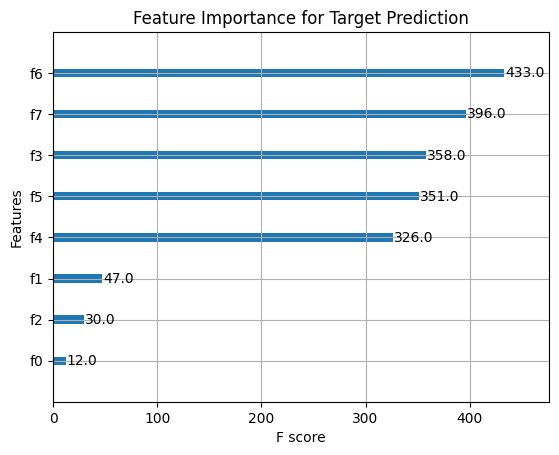

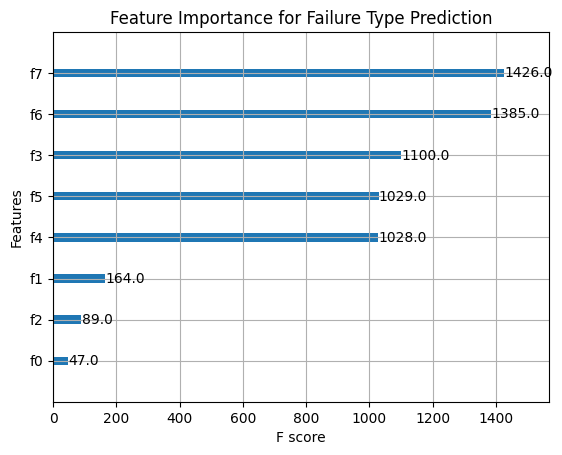

In [32]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance for binary classification (Target)
plot_importance(xgb_target)
plt.title("Feature Importance for Target Prediction")
plt.show()

# Plot feature importance for multi-class classification (Failure Type)
plot_importance(xgb_failure_type)
plt.title("Feature Importance for Failure Type Prediction")
plt.show()


**Deploying model on streamlit**

In [33]:
import joblib

# Save the model
joblib.dump(xgb_target, 'xgb_target_model.pkl')
joblib.dump(xgb_failure_type, 'xgb_failure_type_model.pkl')

# Load the model
loaded_xgb_target = joblib.load('xgb_target_model.pkl')
loaded_xgb_failure_type = joblib.load('xgb_failure_type_model.pkl')
